In [1]:
import chemprop
import seaborn as sns
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict, KFold
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
import numpy as np
import matplotlib.pyplot as plt
from joblib import dump, load

23.855212715598935 0.8931959606735146


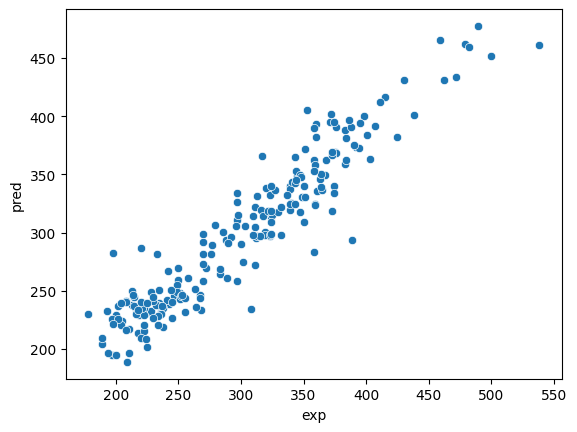

In [2]:
a = pd.read_csv('../predictions/MPNN.csv')
a.drop(columns=['SMILES'], inplace=True)

mpnn_rmse = mean_squared_error(a['exp'], a['pred'], squared=False)
mpnn_r2 = r2_score(a['exp'], a['pred'])
sns.scatterplot(data=a, x="exp", y="pred")

print(mpnn_rmse, mpnn_r2)

<Axes: xlabel='exp', ylabel='pred'>

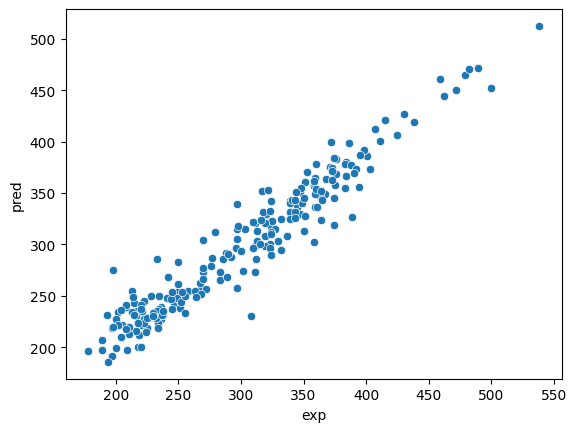

In [3]:
b = pd.read_csv('../predictions/SEMPNN.csv')
b.drop(columns=['SMILES'], inplace=True)

sempnn_rmse = mean_squared_error(b['exp'], b['pred'], squared=False)
sempnn_r2 = r2_score(b['exp'], b['pred'])
sns.scatterplot(data=b, x="exp", y="pred")

---

1. 训练模型
2. 保存模型ckp
3. 预测

In [5]:
radius = 2
size = 8192
data_path = '../datasets/tg/tg.csv'
data = pd.read_csv(data_path)
data['mol'] = data['SMILES'].apply(Chem.MolFromSmiles)
target = data[data.columns[1]].to_numpy()

In [6]:
# 1.训练模型
mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=radius,fpSize=size)

# 二进制摩根指纹
fp_list = []
for mol in data["mol"]:
    fp = mfpgen.GetFingerprintAsNumPy(mol)
    fp_list.append(fp)
fp_array = np.array(fp_list)
feature_binary = fp_array

X_train, X_test, y_train, y_test = train_test_split(feature_binary, target, test_size=0.2, random_state=42)
rf_binary = RandomForestRegressor(random_state=42)
rf_binary.fit(X_train, y_train)

y_pred = rf_binary.predict(X_test)
print('二进制摩根指纹', np.sqrt(mean_squared_error(y_test, y_pred)),r2_score(y_test, y_pred))


# 计数摩根指纹
cfp_list = []
for mol in data["mol"]:
    cfp = mfpgen.GetCountFingerprintAsNumPy(mol)
    cfp_list.append(cfp)
cfp_array = np.array(cfp_list)
feature_count = cfp_array

X_train, X_test, y_train, y_test = train_test_split(feature_count, target, test_size=0.2, random_state=84)
rf_count = RandomForestRegressor(random_state=42)
rf_count.fit(X_train, y_train)


y_pred = rf_count.predict(X_test)
print('计数摩根指纹', np.sqrt(mean_squared_error(y_test, y_pred)),r2_score(y_test, y_pred))

二进制摩根指纹 37.9243744718842 0.7123871102555175
计数摩根指纹 36.86885129151104 0.7266634603048381


In [7]:
# 2.保存模型
dump(rf_binary, '../checkpoints/tg-RF/rf_binary.pkl')
dump(rf_count, '../checkpoints/tg-RF/rf_count.pkl')

['../checkpoints/tg-RF/rf_count.pkl']

In [8]:
# 3.加载模型，多折评估
rf_binary = load('../checkpoints/tg-RF/rf_binary.pkl')
kf = KFold(n_splits=5, shuffle=True, random_state=41)


y_pred = cross_val_predict(rf_binary, feature_binary, target, cv=kf)
c = pd.DataFrame({'exp': target, 'pred': y_pred})
rf_binary_rmse = np.sqrt(mean_squared_error(target, y_pred))
rf_binary_r2 = r2_score(target, y_pred)
print(f"Binary Overall RMSE: {rf_binary_rmse}")
print(f"Binary Overall R2: {rf_binary_r2}")

rf_count = load('../checkpoints/tg-RF/rf_count.pkl')
kf = KFold(n_splits=5, shuffle=True, random_state=42)

y_pred = cross_val_predict(rf_count, feature_count, target, cv=kf)
d = pd.DataFrame({'exp': target, 'pred': y_pred})
rf_count_rmse = np.sqrt(mean_squared_error(target, y_pred))
rf_count_r2 = r2_score(target, y_pred)

print(f"Count Overall RMSE: {rf_count_rmse}")
print(f"Count Overall R2: {rf_count_r2}")

Binary Overall RMSE: 43.4885026018579
Binary Overall R2: 0.6450476959615519
Count Overall RMSE: 41.18194123862458
Count Overall R2: 0.6817014060371368


In [9]:
# 这边需要硬编码的原因是，RF模型采用的是k折交叉验证得到的性能，而MPNN模型则是在整个数据集上得到的性能，因此性能会偏好
# 所以这里使MPNN模型的性能为之前训练模型时得到的性能

mpnn_rmse = 31.26
mpnn_r2 = 0.77
sempnn_rmse = 27.08
sempnn_r2 = 0.82

<Figure size 2000x1400 with 0 Axes>

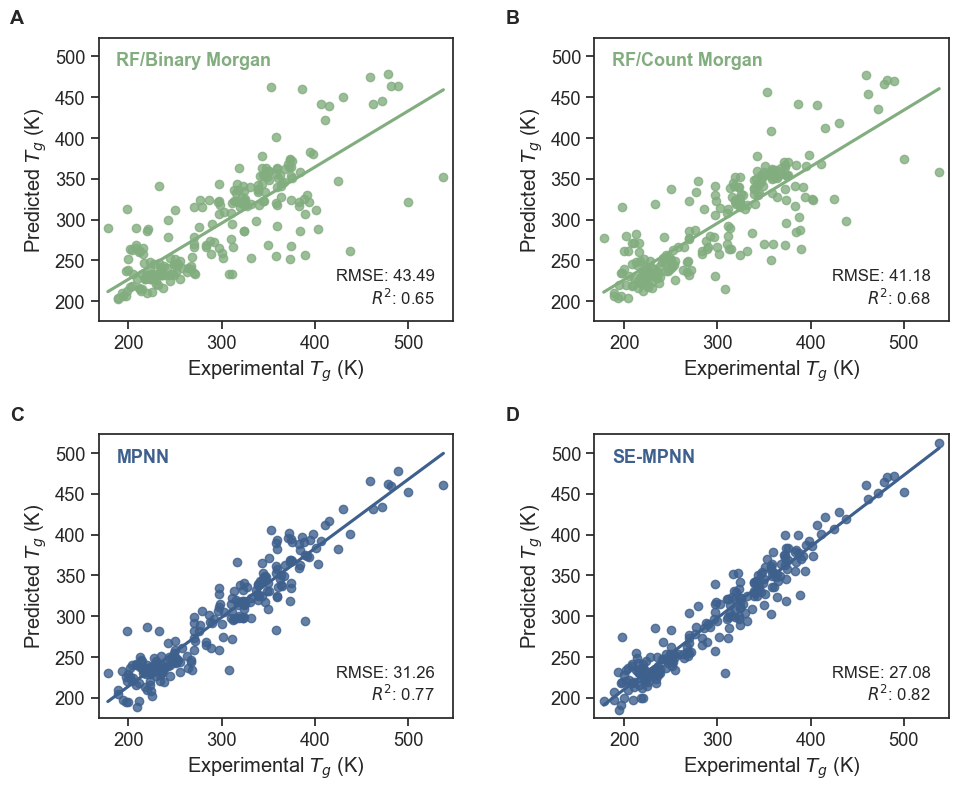

In [13]:
sns.set_theme(style="ticks", font_scale=1.2)
plt.figure(figsize=(20, 14))





# 创建子图布局
fig, axs = plt.subplots(2, 2, figsize=(10, 8))




# 所有数据集的 x 和 y 轴数据
all_exp = pd.concat([a['exp'], b['exp'], c['exp'], d['exp']])
all_pred = pd.concat([a['pred'], b['pred'], c['pred'], d['pred']])

# 设置所有子图的坐标轴刻度范围
for ax in axs.flat:
    ax.set_xlim(all_exp.min()-10, all_exp.max()+10)
    ax.set_ylim(all_pred.min()-10, all_pred.max()+10)

sns.regplot(x='exp', y='pred', data=c, ci=None, ax=axs[0,0], color='#82AD7F')
sns.regplot(x='exp', y='pred', data=d, ci=None, ax=axs[0,1], color='#82AD7F')
sns.regplot(x='exp', y='pred', data=a, ci=None, ax=axs[1,0], color='#3E608D')
sns.regplot(x='exp', y='pred', data=b, ci=None, ax=axs[1,1], color='#3E608D')

plt.subplots_adjust(left=0.1, right=0.95, bottom=0.1, top=0.95, wspace=0.4, hspace=0.4)


# 在每个子图的左上方添加文字标签
axs[0, 0].text(0.95, 0.05, f'RMSE: {rf_binary_rmse:.2f}\n'+'${R^2}$' f': {rf_binary_r2:.2f}', transform=axs[0, 0].transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right')
axs[0, 1].text(0.95, 0.05, f'RMSE: {rf_count_rmse:.2f}\n'+'${R^2}$' f': {rf_count_r2:.2f}', transform=axs[0, 1].transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right')
axs[1, 0].text(0.95, 0.05, f'RMSE: {mpnn_rmse:.2f}\n'+'${R^2}$' f': {mpnn_r2:.2f}', transform=axs[1, 0].transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right')
axs[1, 1].text(0.95, 0.05, f'RMSE: {sempnn_rmse:.2f}\n'+'${R^2}$' f': {sempnn_r2:.2f}', transform=axs[1, 1].transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right')


# 在每个子图的左上方添加文字标签
axs[0, 0].text(0.05, 0.95, 'RF/Binary Morgan', transform=axs[0, 0].transAxes, fontsize=13, verticalalignment='top', weight='bold', color='#82AD7F')
axs[0, 1].text(0.05, 0.95, 'RF/Count Morgan', transform=axs[0, 1].transAxes, fontsize=13, verticalalignment='top', weight='bold', color='#82AD7F')
axs[1, 0].text(0.05, 0.95, 'MPNN', transform=axs[1, 0].transAxes, fontsize=13, verticalalignment='top', weight='bold', color='#3E608D')
axs[1, 1].text(0.05, 0.95, 'SE-MPNN', transform=axs[1, 1].transAxes, fontsize=13, verticalalignment='top', weight='bold', color='#3E608D')



# 设置每个子图的 x 轴和 y 轴标签
axs[0, 0].set_xlabel('Experimental ${T_g}$ (K)')
axs[0, 0].set_ylabel('Predicted ${T_g}$ (K)')
axs[0, 1].set_xlabel('Experimental ${T_g}$ (K)')
axs[0, 1].set_ylabel('Predicted ${T_g}$ (K)')
axs[1, 0].set_xlabel('Experimental ${T_g}$ (K)')
axs[1, 0].set_ylabel('Predicted ${T_g}$ (K)')
axs[1, 1].set_xlabel('Experimental ${T_g}$ (K)')
axs[1, 1].set_ylabel('Predicted ${T_g}$ (K)')

axs[0, 0].annotate("A", xy=(-0.25, 1.1), xycoords="axes fraction", fontsize=14, fontweight="bold", ha="left", va="top")
axs[0, 1].annotate("B", xy=(-0.25, 1.1), xycoords="axes fraction", fontsize=14, fontweight="bold", ha="left", va="top")
axs[1, 0].annotate("C", xy=(-0.25, 1.1), xycoords="axes fraction", fontsize=14, fontweight="bold", ha="left", va="top")
axs[1, 1].annotate("D", xy=(-0.25, 1.1), xycoords="axes fraction", fontsize=14, fontweight="bold", ha="left", va="top")


# fig.tight_layout()
fig.savefig('../figures/plot.png', dpi=300)